In [10]:
#Libraries for the Project

import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV,RandomizedSearchCV
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report, confusion_matrix

from sklearn.compose import ColumnTransformer

INFO 698 Notebook
Created 10/7/2025

Academic Data Analysis Capstone Project

In [23]:
import pandas as pd
raw_data = pd.read_csv('DataSets/RawData.csv')

#print(raw_data.head())

Data Preparation:
We wil clean and modify the data set in preparation for bulding our models

Load the base data set used for analysis and view the head

In [18]:
#load dataset with null Term GPA excluded
data_set = pd.read_csv('DataSets/RawDataWithStudentsRemoved.csv')

print(data_set.head())

#data_set.dtypes
#data_set.shape


   FakeIdentifier  Age  Gender PrimaryMilitaryAffiliation AcademicCareer  \
0               1   18  Female    No Military Affiliation  Undergraduate   
1               2   72    Male    No Military Affiliation            Law   
2               3   26    Male    No Military Affiliation       Graduate   
3               4   47  Female                    Veteran       Graduate   
4               5   45    Male    No Military Affiliation  Undergraduate   

                          College  NumberofClassesEnrolled  TermGPA  \
0              College of Science                        4     3.75   
1   James E Rogers College of Law                        3     4.00   
2          College of Engineering                        2      NaN   
3       Coll of Ag Life & Env Sci                        2     4.00   
4  College of Information Science                        2     2.00   

   CumulativeGPA  UnitsPassedincludedinGPA  UnitsPassednotincludedinGPA  \
0          3.636                         

We review the count of null values for each feature of the data set.

In [ ]:

data_set_nulls = data_set.isnull().sum()
print(data_set_nulls)

We remove all rows (observations) where the target feature, *TermGPA* is NULL. 

We do not want to impute these missing values for our analysis.

In [19]:
data_set = data_set.dropna(subset = ['TermGPA'])

Below is acheck to confirm no NULL values remain in the data set.

In [ ]:
#no nulls
data_set_nulls = data_set.isnull().sum()
print(data_set_nulls)

In [ ]:
#mean and standard dev by College

mean_by_college = data_set.groupby('College')['TermGPA'].mean()
print(mean_by_college)

stdev_by_college = data_set.groupby('College')['TermGPA'].std()
print(stdev_by_college)

In [17]:
# mean and quantiles

mean_termgpa = data_set['TermGPA'].mean()
print(mean_termgpa)


#75th percentile
q3_termgpa = np.percentile(data_set['TermGPA'], 50)

print(q3_termgpa)

3.1899030214688042
3.75


We define the features and parameters for the Random Forest Classifier Model. 

We set our *TermGPA* target column, define the test/train split percentage, select which features to remove from the model, and specify the categorical features which require a one-hot encoding for the RF model.



In [4]:
#Split the Data Set

# Y target column
target_column = 'TermGPA'
test_percent = 0.20

#x_columns_to_drop = ['FakeIdentifier' , 'TermGPA']

#data set dropping the target feature
x_features = data_set.drop(['FakeIdentifier' ,
                             #'College',
                             'CumulativeGPA',
                             #'UnitsPassedincludedinGPA',
                             'TermGPA'],
                               axis = 1)


#encoding categorical features
columns_to_encode = ['Gender',
                      'PrimaryMilitaryAffiliation',
                        'AcademicCareer',
                          'College',
                      'UAFullTimePartTime',
                        'AcademicLevelEndofTerm',
                          'FirstGenerationFlag' 
                          ]


y_target = data_set[target_column]


#split the data into a 80/20 train test split using the same random seed for consistency
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size = test_percent, random_state = 698) 

#encode categorical features, and drop one level to avoid multicolinearity
x_train_encoded = pd.get_dummies(x_train,
                                  columns=columns_to_encode,
                                    drop_first=True,
                                      dtype = int)
x_test_encoded = pd.get_dummies(x_test,
                                 columns=columns_to_encode,
                                 drop_first=True,
                                   dtype = int)
# restore missing features after encoding
x_train_features_encoded_cols = x_train_encoded.columns
x_test_encoded = x_test_encoded.reindex(columns=x_train_features_encoded_cols, fill_value=0)

In [41]:

gpa_bins = [0, 2.0, 3.1, 3.4, 3.75, 4.0]
gpa_bin_labels = ['Warn', 'Pass', 'middle', 'Good', 'Excellent']

#binning the target into quartiles
#quantile_labels = ['Q1','Q2','Q3']

#y_train_binned, bins = pd.qcut(y_train, q=4, labels=False, retbins=True, duplicates = 'drop')


y_train_binned = pd.cut(y_train, bins=gpa_bins, include_lowest=True, labels=gpa_bin_labels)

#bin y test wiht the same bins as y train
y_test_binned = pd.cut(y_test, bins=gpa_bins, include_lowest=True, labels=gpa_bin_labels)

-1.5912154740192466
1.5346880530063727


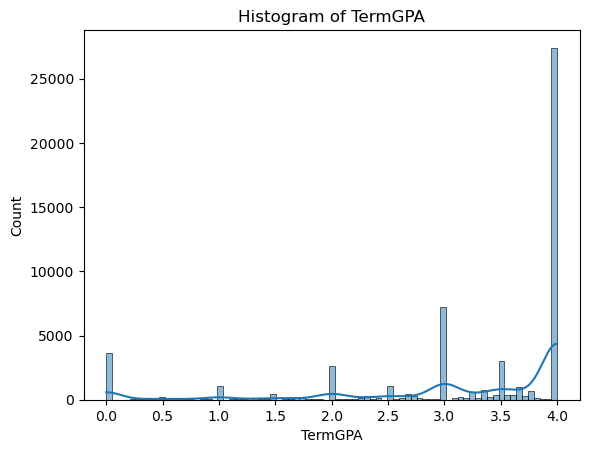

In [21]:
#notnormally distributed

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
skew_termgpa = skew(data_set['TermGPA'])

kurtosis_termgpa = kurtosis(data_set['TermGPA'], axis=0, fisher=True, bias=True, nan_policy='propagate')

print(skew_termgpa)
print(kurtosis_termgpa)

sns.histplot(data_set['TermGPA'], kde=True)
plt.title('Histogram of TermGPA')
plt.show()

We set additional model parametrs and define the model as RFC. 

We use a consistent random seed parameter (698) where appropriate to ensure consistent behavior when training the model.

In [42]:
# the RF Calssifier model

metric = accuracy_score
metric_name = "accuracy"
rfc_depth = 20
rfc_max_features = None # None, sqrt or log2
rfc_min_sample_split = 10
#rfc_criterion = 'squared_error' #criterion{“squared_error”, “absolute_error”, “friedman_mse”, “poisson”}, default=”squared_error”
rfc_estimators = 200

model = RandomForestClassifier(n_estimators = rfc_estimators,
                                 max_features = rfc_max_features,
                                    min_samples_split=rfc_min_sample_split,
                                      max_depth = rfc_depth,
                                          random_state=698)


We fit our trained RFC model to our test set. 

Then, we view the score of the model, based on our selected accuracy metric.

In [43]:
#fit the model
model.fit(x_train_encoded, y_train_binned)

# Predict using test data
y_pred = model.predict(x_test_encoded) 

    # compare prediction to actual dev/test data
score = metric(y_test_binned, y_pred)
print(f"{metric_name} on test set: {score:.4f}") 

#r_squared = r2_score(y_test, y_pred)
#print(f"r_squared on test set: {r_squared:.4f}") 

accuracy on test set: 0.5626


In [29]:
print(y_pred)

['Excellent' 'Excellent' 'Excellent' ... 'Excellent' 'Excellent'
 'Excellent']


In [32]:
#feature importances:
feature_importances = model.feature_importances_ 
print(feature_importances)

feature_names = x_train_encoded.columns 
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
pd.set_option('display.max_rows', None)
print(feature_importance_df.sort_values(by = 'Importance', ascending = False))

[1.68493775e-01 5.81373289e-02 3.45534839e-01 1.01223000e-02
 9.13401006e-02 3.09612549e-02 9.55458081e-04 4.48751914e-03
 3.40819150e-03 1.76143109e-02 1.06396471e-02 3.07000611e-03
 8.41722011e-04 1.08120504e-02 1.33706815e-03 1.07921925e-02
 7.48069900e-03 1.20124143e-03 2.16525318e-03 4.86511144e-03
 1.94534133e-03 5.91493754e-03 9.82263675e-03 7.90272567e-07
 1.64282975e-03 2.28414680e-03 7.81016419e-03 8.67829082e-03
 2.10796137e-03 1.65341255e-02 1.10526212e-03 3.83905046e-04
 1.35493806e-03 3.52693621e-03 4.29028559e-03 1.29015856e-02
 6.12880104e-02 1.43312154e-02 1.59793488e-03 1.65707855e-02
 1.31278024e-02 2.85200448e-02]
                                              Feature    Importance
2                            UnitsPassedincludedinGPA  3.455348e-01
0                                                 Age  1.684938e-01
4                                        AcademicYear  9.134010e-02
36                    AcademicLevelEndofTerm_Graduate  6.128801e-02
1                 

In [35]:
result = permutation_importance(model, x_test_encoded, y_test_binned, scoring = 'accuracy', n_repeats=10, random_state=698, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

permutation_importances = pd.Series(result.importances_mean[sorted_idx], index=x_test_encoded.columns[sorted_idx]).sort_values(ascending=False)
print("\nPermutation Importance:")
print(permutation_importances)


Permutation Importance:
UnitsPassedincludedinGPA                                   0.118346
NumberofClassesEnrolled                                    0.021171
AcademicLevelEndofTerm_Graduate                            0.010518
College_Eller College of Management                        0.008908
Age                                                        0.004436
AcademicLevelEndofTerm_Senior                              0.003851
UAFullTimePartTime_P                                       0.002060
AcademicLevelEndofTerm_Junior                              0.000864
PrimaryMilitaryAffiliation_Other Dependent                 0.000495
PrimaryMilitaryAffiliation_No Military Affiliation         0.000414
AcademicYear                                               0.000405
College_Undergraduate Education                            0.000351
FirstGenerationFlag_Y                                      0.000351
College_College of Information Science                     0.000261
College_Coll of Ag Life

In [21]:
numeric_features = x_train.select_dtypes(include=['number']).columns

categorical_features = x_train.select_dtypes(include=['category', 'object']).columns

#categorical_features = [ ['Gender',
                  #    'PrimaryMilitaryAffiliation',
                  #      'AcademicCareer',
                   #       'College',
                    #  'UAFullTimePartTime',
                    #    'AcademicLevelEndofTerm',
                      #    'FirstGenerationFlag' 
                      #    ]]

#preprocessor = ColumnTransformer(
    #transformers=[
   #     ('num', StandardScaler(), numeric_features),
   #     ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
  #  ])

In [20]:
scaler = StandardScaler()

In [22]:
x_train_scaled_numeric = scaler.fit_transform(x_train[numeric_features])
x_train_scaled_numeric_df = pd.DataFrame(x_train_scaled_numeric, columns=numeric_features, index=x_train.index)


x_test_scaled_numeric = scaler.transform(x_test[numeric_features])
x_test_scaled_numeric_df = pd.DataFrame(x_test_scaled_numeric, columns=numeric_features, index=x_test.index)


In [23]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop = 'first')

#fit encoder on trianing data to ensure all training columns are accounted for when testing
encoder.fit(x_train[categorical_features])

#encode train data
x_train_encoded_categorical = encoder.fit_transform(x_train[categorical_features])
x_train_encoded_categorical_df = pd.DataFrame(x_train_encoded_categorical, columns=encoder.get_feature_names_out(categorical_features), index=x_train.index)

# Combine train processed features into a data frame
x_train_processed = pd.concat([x_train_scaled_numeric_df, x_train_encoded_categorical_df], axis=1)

#view the trainig data
print("Processed Training Data:")
print(x_train_processed.head())


#encode test data which is already fir to x train features-- do not fit again
x_test_encoded_categorical = encoder.transform(x_test[categorical_features])
x_test_encoded_categorical_df  = pd.DataFrame(x_test_encoded_categorical, columns=encoder.get_feature_names_out(categorical_features), index=x_test.index)
#combine test data
x_test_processed = pd.concat([x_test_scaled_numeric_df, x_test_encoded_categorical_df], axis=1)

Processed Training Data:
            Age  NumberofClassesEnrolled  UnitsPassedincludedinGPA  \
56270 -0.539109                 0.974270                  0.230987   
21219 -0.649295                -0.473828                  0.230987   
38914 -0.759480                 0.974270                  1.410530   
55496 -0.098368                -1.197878                 -0.653671   
13089 -0.428924                -0.473828                 -0.653671   

       UnitsPassednotincludedinGPA  AcademicYear  Gender_Male  Gender_Unknown  \
56270                     1.538662     -0.524874          0.0             0.0   
21219                    -0.172738     -1.130808          0.0             0.0   
38914                    -0.172738     -0.524874          0.0             0.0   
55496                    -0.172738      1.292927          0.0             0.0   
13089                    -0.172738     -1.736742          0.0             0.0   

       PrimaryMilitaryAffiliation_Child Dependent  \
56270         

In [ ]:
#processed_data = preprocessor.fit_transform(data_set)

# If you want to get a DataFrame back with named columns
# Get feature names after one-hot encoding
#ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
#all_feature_names = numeric_features + list(ohe_feature_names)

#processed_df = pd.DataFrame(processed_data, columns=all_feature_names)

In [9]:
#scale the data sets for KNN
scaler = StandardScaler()


# KNN Models

We perform a K nearest Neighbors Regression after scaling and tranformsing the train and test data sets. 


In [14]:
# KNN Regressor Model
k_value = 5
knn_regression_model = KNeighborsRegressor(n_neighbors = k_value)

knn_regression_model.fit(x_train_processed, y_train)

KNeighborsRegressor()

In [24]:
# predict for KNN

knn_y_pred = knn_regression_model.predict(x_test_processed)
print(knn_y_pred)


knn_accuracy = mean_squared_error(y_test, knn_y_pred) 
knn_rmse = np.sqrt(knn_accuracy)

knn_rsquared = r2_score(y_test, knn_y_pred)


print(f"Root Mean Squared Error (RMSE): {knn_rmse:.2f}")
print(f"R-squared (R2) Score: {knn_rsquared:.2f}")

[3.58   4.     3.9334 ... 3.9    4.     4.    ]
Root Mean Squared Error (RMSE): 0.88
R-squared (R2) Score: 0.43


In [ ]:
#add mean and standard dev by College to dataframe

#data_set['meanTermGPACol'] = data_set.groupby('College')['TermGPA'].transform('mean')
#data_set['stdevTermGPACol'] = data_set.groupby('College')['TermGPA'].transform('std')
#data_set['ZTermGPA'] = data_set.groupby('College')['TermGPA'].transform(zscore)

#print(data_set[['FakeIdentifier', 'TermGPA','College' ,'meanTermGPACol','stdevTermGPACol', 'ZTermGPA' ]].head())

In [ ]:
#create classes from normalized Term GPA
# very low z < -1.5
#low -1.5 to -0.5
#average -0.5 to 0.5
#above average 0.5 to 1.5
#very above avg > 1.5

#data_set['ClassTermGPA'] = ['WellBelowAverage' if 'ZTermGPA' < -1.5
                               #else 'BelowAverage' if ('ZTermGPA' < -0.5 & 'ZTermGPA' >= -1.5)
                              # else 'Average' if ('ZTermGPA' >=-0.5 & 'ZTermGPA' < 0.5)
                              # else 'AboveAverage' if 'ZTermGPA' >= 0.5 & 'ZTermGPA' < 1.5
                               #else 'WellAboveAverage' if 'ZtermGPA' >=1.5
                               #else 'NA']



#data_set['ClassTermGPA'] = ['WellBelowAverage' if ztermgpa < -1.5
                               #else 'BelowAverage' if (ztermgpa < -0.5 and ztermgpa >= -1.5)
                               #else 'Average' if (ztermgpa >=-0.5 and ztermgpa < 0.5)
                               #else 'AboveAverage' if ztermgpa >= 0.5 and ztermgpa < 1.5
                               #else 'WellAboveAverage' if ztermgpa >=1.5
                               #else 'NA' for ztermgpa in data_set['ZTermGPA']]

#print(data_set[['FakeIdentifier','ZTermGPA','ClassTermGPA']])

55569
